In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp

import sys
sys.path.insert(1, '../')
import models
import utils
import matplotlib.pyplot as plt

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mean = lambda x: jnp.zeros_like(x)
kernel = lambda x,y : jnp.exp(-jnp.sum((x-y)**2)/2)

def kernel_matrix(xs, ys):
    kernel_fn = jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(ys))
    return kernel_fn(xs)

def sample(xs, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    samples = jax.random.multivariate_normal(key, mean=mean(xs), cov=kernel_matrix(xs, xs), method='svd')
    return samples

In [3]:
def posterior_predictive_moments(xs, ys, x, key=None):
    '''
    posterior over x positions given (xs, ys), noise free setting, eq. (2.19) in Rasmussen & Williams
    '''
    if key is None:
        key = jax.random.PRNGKey(0)
    k = kernel_matrix(xs, xs)
    k_s = kernel_matrix(xs, x)
    k_ss = kernel_matrix(x, x)
    k_inv = jnp.linalg.inv(k)
    mu = k_s.T @ k_inv @ ys
    cov = k_ss - k_s.T @ k_inv @ k_s
    return mu, cov

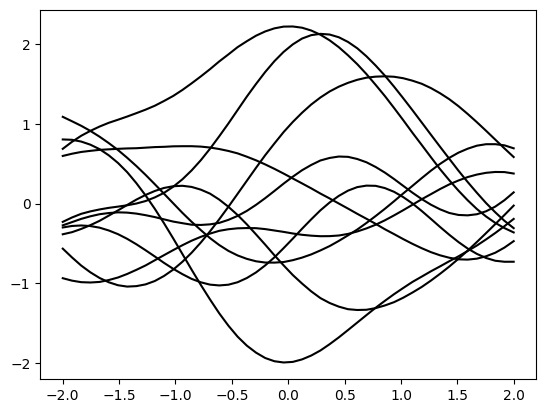

In [4]:
xs = jnp.linspace(-2, 2, 50)

key = jax.random.PRNGKey(1)
for _ in range(10):
    subkey, key = jax.random.split(key)
    ys = sample(xs, subkey)
    plt.plot(xs, ys, c='k')

(array([  1.,   1.,   2.,   0.,   7.,  11.,  11.,  18.,  21.,  31.,  61.,
         81., 102., 134., 191., 194., 266., 334., 366., 411., 490., 492.,
        562., 623., 555., 634., 582., 507., 526., 484., 444., 350., 365.,
        267., 206., 164., 149.,  98.,  64.,  66.,  46.,  26.,  21.,  15.,
          9.,   5.,   4.,   0.,   2.,   1.]),
 array([-3.76616478, -3.61582112, -3.46547747, -3.31513381, -3.16479015,
        -3.0144465 , -2.86410284, -2.71375918, -2.56341553, -2.41307163,
        -2.26272798, -2.11238432, -1.96204078, -1.81169701, -1.66135335,
        -1.51100969, -1.36066604, -1.21032238, -1.05997872, -0.90963501,
        -0.75929135, -0.60894769, -0.45860401, -0.30826035, -0.15791668,
        -0.00757301,  0.14277066,  0.29311433,  0.44345799,  0.59380168,
         0.74414533,  0.89448899,  1.04483271,  1.19517636,  1.34552002,
         1.49586368,  1.64620733,  1.79655099,  1.94689476,  2.0972383 ,
         2.24758196,  2.39792562,  2.54826951,  2.69861317,  2.84895682,
 

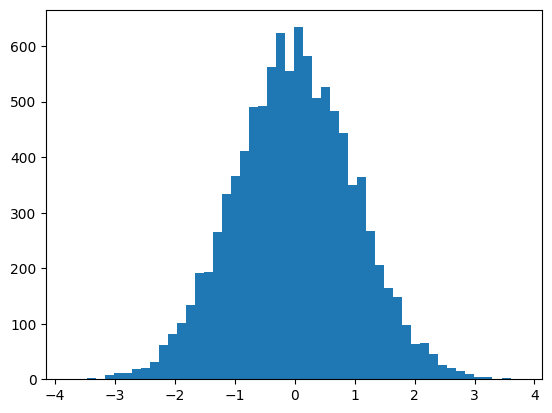

In [5]:
x = jnp.array([0.])

key = jax.random.PRNGKey(1)
ys = []
for _ in range(10000):
    subkey, key = jax.random.split(key)
    y = sample(x, subkey)
    ys.append(y[0])

ys = jnp.array(ys)
plt.hist(ys, bins=50)

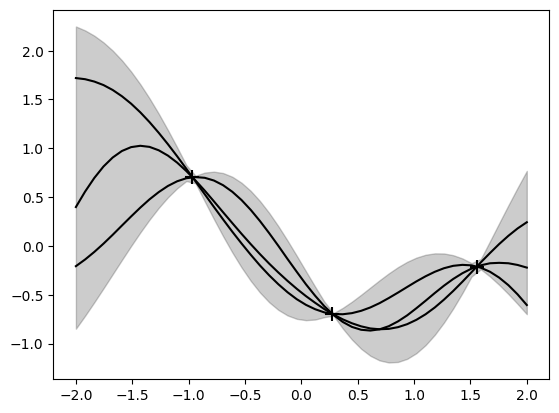

In [6]:
key = jax.random.PRNGKey(1)
true_xs = jax.random.uniform(key, minval=-2, maxval=2, shape=(3,))
true_ys = sample(true_xs, key)

fig, ax = plt.subplots()

# Posterior 
mu_post, cov_post = posterior_predictive_moments(true_xs, true_ys, xs) 
ax.fill_between(xs, mu_post - 2*jnp.sqrt(jnp.diag(cov_post)), mu_post + 2*jnp.sqrt(jnp.diag(cov_post)), color='k', alpha=0.2)

for _ in range(3):
    key, subkey = jax.random.split(key)
    posterior_ys = jax.random.multivariate_normal(key, mean=mu_post, cov=cov_post, method='svd')

    ax.plot(xs, posterior_ys, c='k')

# True
ax.scatter(true_xs, true_ys, marker='+', c='k', s=100)

# hierarchical GP

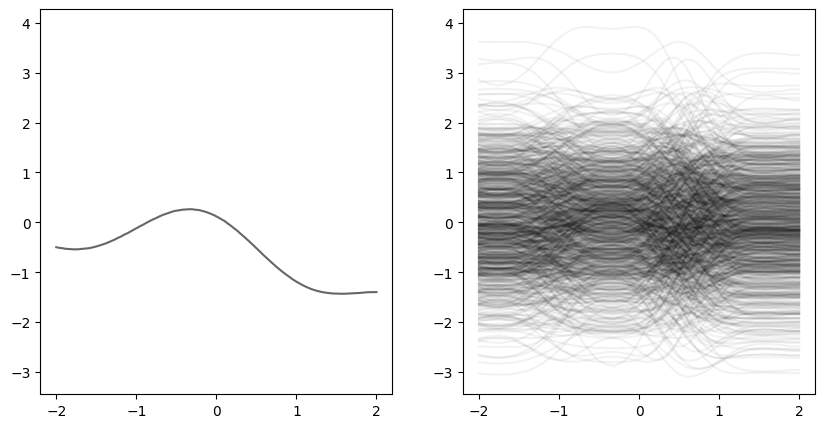

In [100]:
ts = jnp.linspace(-2, 2, 100)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

thetas = sample(ts, key)
axs[0].plot(ts, thetas, c='k', alpha=0.6)
for _ in range(1000):
    subkey, key = jax.random.split(key)
    As = sample(thetas, key)
    axs[1].plot(ts, As, c='k', alpha=0.05)
axs[0].sharey(axs[1])